<a href="https://colab.research.google.com/github/chenxicclu/MIDS_NLP_Project/blob/main/ComVE_Subtask_B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set up

First need go to "Runtime" --> "Change Runtime Type" and choose GPU.  
Then confirm that GPU is detected.

In [6]:
!nvidia-smi

Fri Apr  9 17:08:06 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    32W / 250W |    349MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [8]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [9]:
!pip install transformers
!pip install pytorch-lightning
!pip install sentencepiece

  Using cached https://files.pythonhosted.org/packages/e6/13/fb401b8f9d9c5e2aa08769d230bb401bf11dee0bc93e069d7337a4201ec8/pytorch_lightning-1.2.7-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/3a/42/d984612cabf005a265aa99c8d4ab2958e37b753aafb12f31c81df38751c8/torchmetrics-0.2.0-py3-none-any.whl
Processing /root/.cache/pip/wheels/a7/c1/ea/cf5bd31012e735dc1dfea3131a2d5eae7978b251083d6247bd/PyYAML-5.3.1-cp37-cp37m-linux_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/62/11/f7689b996f85e45f718745c899f6747ee5edb4878cadac0a41ab146828fa/fsspec-0.9.0-py3-none-any.whl
Processing /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e/future-0.18.2-cp37-none-any.whl
  Using cached https://files.pythonhosted.org/packages/88/c0/5890b4c8b04a79b7360e8fe4490feb0bb3ab179743f199f0e6220cebd568/aiohttp-3.7.4.post0-cp37-cp37m-manylinux2014_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/7c/a6/4123b8165acbe773d1a8dc8e3

In [10]:
import tensorflow as tf
print(tf.__version__)
import pandas as pd
import numpy as np
from transformers import BertTokenizer, BertModel, BertForMultipleChoice, AdamW, get_linear_schedule_with_warmup, BertConfig, BertForSequenceClassification # BERT
from transformers import DebertaTokenizer, DebertaModel # DeBERTa v1
from transformers import DebertaV2Tokenizer, DebertaV2Model # DeBERTa v2

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset, DataLoader, RandomSampler, SequentialSampler

import random
from sklearn.model_selection import train_test_split
import pytorch_lightning as pl
from pytorch_lightning.metrics.functional.classification import auroc
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

from sklearn.metrics import classification_report

import time
import datetime


2.4.1


# Datasets

In [11]:
n = 200
m = 200
t = 1000

### Read in Original Datasets

Training data

In [12]:
train_b_data = pd.read_csv("https://github.com/chenxicclu/SemEval2020-Task4-Commonsense-Validation-and-Explanation/raw/master/ALL%20data/Training%20%20Data/subtaskB_data_all.csv",keep_default_na=False)
print(train_b_data.shape)
print(train_b_data.info())
train_b_data.head(30)

(10000, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         10000 non-null  int64 
 1   FalseSent  10000 non-null  object
 2   OptionA    10000 non-null  object
 3   OptionB    10000 non-null  object
 4   OptionC    10000 non-null  object
dtypes: int64(1), object(4)
memory usage: 390.8+ KB
None


,id,FalseSent,OptionA,OptionB,OptionC
0,0,He poured orange juice on his cereal.,Orange juice is usually bright orange.,Orange juice doesn't taste good on cereal.,Orange juice is sticky if you spill it on the ...
1,1,He drinks apple.,Apple juice are very tasty and milk too,Apple can not be drunk,Apple cannot eat a human
2,2,"Jeff ran 100,000 miles today","100,000 miles is way to long for one person to...","Jeff is a four letter name and 100,000 has six...","100,000 miles is longer than 100,000 km."
3,3,I sting a mosquito,A human is a mammal,A human is omnivorous,A human has not stings
4,4,A giraffe is a person.,Giraffes can drink water from a lake.,A giraffe is not a human being.,.Giraffes usually eat leaves.
5,5,A normal closet is larger than a walk-in closet.,Walk-in closets are normal closets.,A person can sleep in a walk-in closet.,A person cannot walk into a normal closet beca...
6,6,I like to ride my chocolate,Chocolate is delicious and bikes are not,"Chocolate is a food, not a transportation unit",My bike can't ride a chocolate
7,7,A GIRL WON THE RACE WITH HORSE,GIRL HAVE BEAUTIFUL HAIR BUT THE HORSE DOESN'T...,THE GIRL WEAR DRESS BUT THE HORSE DOESN'T HAVE .,HORSE RAN FASTER THAN HER
8,8,he put elephant into the jug,elephants is an animal and jug is a thing,a jug is so small than an elephant,jug is used for store things
9,9,A dog plays volleyball,Only humans play volleyball,Dogs are not wild animals,Humans trust dogs


Training labels

In [13]:
train_b_label = pd.read_csv("https://github.com/chenxicclu/SemEval2020-Task4-Commonsense-Validation-and-Explanation/raw/master/ALL%20data/Training%20%20Data/subtaskB_answers_all.csv",header=None)
print(train_b_label.shape)
# check label distribution --> balanced
print(train_b_label[1].value_counts())
train_b_label.head()


(10000, 2)
C    3443
B    3362
A    3195
Name: 1, dtype: int64


,0,1
0,0,B
1,1,B
2,2,A
3,3,C
4,4,B


Dev and test data and labels

In [14]:
dev_b_data = pd.read_csv("https://github.com/chenxicclu/SemEval2020-Task4-Commonsense-Validation-and-Explanation/raw/master/ALL%20data/Dev%20Data/subtaskB_dev_data.csv")
print(dev_b_data.shape)
dev_b_label = pd.read_csv("https://github.com/chenxicclu/SemEval2020-Task4-Commonsense-Validation-and-Explanation/raw/master/ALL%20data/Dev%20Data/subtaskB_gold_answers.csv",header=None)
print(dev_b_label.shape)
test_b_data = pd.read_csv("https://github.com/chenxicclu/SemEval2020-Task4-Commonsense-Validation-and-Explanation/raw/master/ALL%20data/Test%20Data/subtaskB_test_data.csv")
print(test_b_data.shape)
test_b_label = pd.read_csv("https://github.com/chenxicclu/SemEval2020-Task4-Commonsense-Validation-and-Explanation/raw/master/ALL%20data/Test%20Data/subtaskB_gold_answers.csv",header=None)
print(test_b_label.shape)

(997, 5)
(997, 2)
(1000, 5)
(1000, 2)


Reduce the data size for initial trials

In [15]:
train_b_data = train_b_data[:n]
train_b_label = train_b_label[:n]
dev_b_data = dev_b_data[:m]
dev_b_label = dev_b_label[:m]
test_b_data = test_b_data[:t]
test_b_label = test_b_label[:t]


In [16]:
train_b_data.shape
dev_b_data.shape

(200, 5)

### Reshape the data and labels to fit the model

Reshape training data and labels

In [17]:
# data
df_a = train_b_data[['id','FalseSent','OptionA']]
df_b = train_b_data[['id','FalseSent','OptionB']]
df_c = train_b_data[['id','FalseSent','OptionC']]


for df in df_a,df_b,df_c:
  df.columns = ['id','FalseSent','Option']

train_b_data_concat = pd.concat([df_a, df_b, df_c])

# Add a connection sentence between the false sentence and the option
connect = " No, this doesn't make sense because "
train_b_data_concat['ConnectSent'] = train_b_data_concat['FalseSent'] + connect + train_b_data_concat['Option']

# labels
df_a_label = (train_b_label[1] == "A")
df_b_label = (train_b_label[1] == "B")
df_c_label = (train_b_label[1] == "C")
train_b_label_concat = pd.concat([df_a_label, df_b_label, df_c_label])

train_b_data_concat['Label'] =  train_b_label_concat
train_b_data_concat['Label'] =  train_b_data_concat['Label'].astype(int)

# sort by id (put the same sentences together, 3 as a group)
train_b_data_concat.sort_values(by = 'id', ignore_index= True, inplace=True)

# restructured dataframe
train_b_data_concat.head()



,id,FalseSent,Option,ConnectSent,Label
0,0,He poured orange juice on his cereal.,Orange juice is usually bright orange.,"He poured orange juice on his cereal. No, this...",0
1,0,He poured orange juice on his cereal.,Orange juice doesn't taste good on cereal.,"He poured orange juice on his cereal. No, this...",1
2,0,He poured orange juice on his cereal.,Orange juice is sticky if you spill it on the ...,"He poured orange juice on his cereal. No, this...",0
3,1,He drinks apple.,Apple juice are very tasty and milk too,"He drinks apple. No, this doesn't make sense b...",0
4,1,He drinks apple.,Apple can not be drunk,"He drinks apple. No, this doesn't make sense b...",1


In [18]:
train_b_data_concat.shape

(600, 5)

Reshape dev data and labels

In [19]:
dev_a = dev_b_data[['id','FalseSent','OptionA']]
dev_b = dev_b_data[['id','FalseSent','OptionB']]
dev_c = dev_b_data[['id','FalseSent','OptionC']]


for df in dev_a,dev_b,dev_c:
  df.columns = ['id','FalseSent','Option']

dev_b_data_concat = pd.concat([dev_a, dev_b, dev_c])

connect = " No, this doesn't make sense because "
dev_b_data_concat['ConnectSent'] = dev_b_data_concat['FalseSent'] + connect + dev_b_data_concat['Option']

# labels
dev_label_a = (dev_b_label[1] == "A")
dev_label_b  = (dev_b_label[1] == "B")
dev_label_c  = (dev_b_label[1] == "C")
dev_b_label_concat = pd.concat([dev_label_a, dev_label_b, dev_label_c])

dev_b_data_concat['Label'] =  dev_b_label_concat
dev_b_data_concat['Label'] =  dev_b_data_concat['Label'].astype(int)

# sort by id (put the same sentences together, 3 as a group)
dev_b_data_concat.sort_values(by = 'id', ignore_index= True, inplace=True)

# restructured dataframe
dev_b_data_concat

,id,FalseSent,Option,ConnectSent,Label
0,3,The hangers bought the closet,A hanger is something you put your clothes on,"The hangers bought the closet No, this doesn't...",0
1,3,The hangers bought the closet,Hangers are inanimate things which cannot buy ...,"The hangers bought the closet No, this doesn't...",1
2,3,The hangers bought the closet,The hangers cannot eat,"The hangers bought the closet No, this doesn't...",0
3,5,Straight razors are great for cutting sheet metal,sheet metal is lighter than Straight razors,Straight razors are great for cutting sheet me...,0
4,5,Straight razors are great for cutting sheet metal,The blades of Straight razors are too thin to ...,Straight razors are great for cutting sheet me...,1
...,...,...,...,...,...
595,1975,The dog ate the shark.,The dog cannot eat a shark .,"The dog ate the shark. No, this doesn't make s...",1
596,1975,The dog ate the shark.,Sharks live in the ocean.,"The dog ate the shark. No, this doesn't make s...",0
597,1992,The boy wore uniform to go to restaurant,Restaurant is always crowded,"The boy wore uniform to go to restaurant No, t...",0
598,1992,The boy wore uniform to go to restaurant,Restaurants don't sell uniforms,"The boy wore uniform to go to restaurant No, t...",0


Reshape test data and labels

In [20]:
test_a = test_b_data[['id','FalseSent','OptionA']]
test_b = test_b_data[['id','FalseSent','OptionB']]
test_c = test_b_data[['id','FalseSent','OptionC']]


for df in test_a,test_b,test_c:
  df.columns = ['id','FalseSent','Option']

test_b_data_concat = pd.concat([test_a, test_b, test_c])

connect = " No, this doesn't make sense because "
test_b_data_concat['ConnectSent'] = test_b_data_concat['FalseSent'] + connect + test_b_data_concat['Option']

# labels
test_label_a = (test_b_label[1] == "A")
test_label_b  = (test_b_label[1] == "B")
test_label_c  = (test_b_label[1] == "C")
test_b_label_concat = pd.concat([test_label_a, test_label_b, test_label_c])

test_b_data_concat['Label'] =  test_b_label_concat
test_b_data_concat['Label'] =  test_b_data_concat['Label'].astype(int)

# sort by id (put the same sentences together, 3 as a group)
test_b_data_concat.sort_values(by = 'id', ignore_index= True, inplace=True)

# restructured dataframe
test_b_data_concat



,id,FalseSent,Option,ConnectSent,Label
0,2,when it is hot humidity forms,Laundry will not be dry because of the humidity.,"when it is hot humidity forms No, this doesn't...",0
1,2,when it is hot humidity forms,hotness will evaporate water,"when it is hot humidity forms No, this doesn't...",1
2,2,when it is hot humidity forms,Humidity is a measure of moisture in the atmos...,"when it is hot humidity forms No, this doesn't...",0
3,6,Grizzly bears hate honey.,Grizzly bears have been observed taking stings...,"Grizzly bears hate honey. No, this doesn't mak...",0
4,6,Grizzly bears hate honey.,Bees cannot eat grizzly bears,"Grizzly bears hate honey. No, this doesn't mak...",0
...,...,...,...,...,...
2995,1996,today my hand is very clear to see the world,hands are not used for eating food,today my hand is very clear to see the world N...,0
2996,1996,today my hand is very clear to see the world,people should clean their hands and eyes,today my hand is very clear to see the world N...,0
2997,1997,"Sean is a hard-working guy, so he plays phone ...",hard-working' means he takes time for pressure,"Sean is a hard-working guy, so he plays phone ...",0
2998,1997,"Sean is a hard-working guy, so he plays phone ...",hard-working' means he pay times on serious th...,"Sean is a hard-working guy, so he plays phone ...",1


# Baseline -- BERT

### Tokenize

Import BERT tokenizer

In [16]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# bert = BertModel.from_pretrained('bert-base-uncased')

Count how many words in the sentence, to determin the max sentence length for tokenization

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Max sentence length: 52


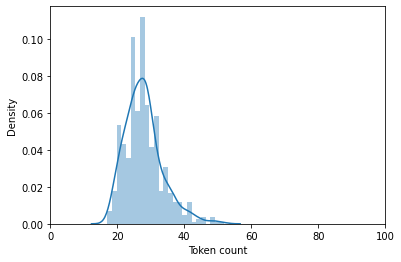

In [17]:
token_b_lens = []
for txt in train_b_data_concat['ConnectSent']:
  tokens_b = bert_tokenizer.encode(str(txt), max_length=512)
  token_b_lens.append(len(tokens_b))

sns.distplot(token_b_lens)
plt.xlim([0, 100])
plt.xlabel('Token count')

print("Max sentence length:", max(token_b_lens))

Tokenize

In [18]:
# As a pair
max_seq_len_b = 36
train_b_token = bert_tokenizer(
    train_b_data_concat['FalseSent'].tolist(),
    train_b_data_concat['Option'].tolist(),
    max_length = max_seq_len_b,
    pad_to_max_length=True,
    truncation=True, 
    return_tensors="pt"
    )

dev_b_token = bert_tokenizer(
    dev_b_data_concat['FalseSent'].tolist(),
    dev_b_data_concat['Option'].tolist(),
    max_length = max_seq_len_b,
    pad_to_max_length=True,
    truncation=True, 
    return_tensors="pt"
    )

test_b_token = bert_tokenizer(
    test_b_data_concat['FalseSent'].tolist(),
    test_b_data_concat['Option'].tolist(),
    max_length = max_seq_len_b,
    pad_to_max_length=True,
    truncation=True, 
    return_tensors="pt"
    )

# Just use the connected sentence
# max_seq_len_b = 60
# train_b_token = bert_tokenizer(
#     train_b_data_concat['ConnectSent'].tolist(),
#     max_length = max_seq_len_b,
#     pad_to_max_length=True,
#     truncation=True, 
#     return_tensors="pt"
#     )

# dev_b_token = bert_tokenizer(
#     dev_b_data_concat['ConnectSent'].tolist(),
#     max_length = max_seq_len_b,
#     pad_to_max_length=True,
#     truncation=True, 
#     return_tensors="pt"
#     )

# test_b_token = bert_tokenizer(
#     test_b_data_concat['ConnectSent'].tolist(),
#     max_length = max_seq_len_b,
#     pad_to_max_length=True,
#     truncation=True, 
#     return_tensors="pt"
#     )



/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [19]:
train_b_token.token_type_ids[0]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

Dataloaders

## Use BertForSequenceClassification

In [ ]:
batch_size = 36 

# Create the DataLoader for our training set. (RandomSampler)
train_tensor_data = TensorDataset(train_b_inputs, train_b_masks, train_b_labels)
train_sampler = RandomSampler(train_tensor_data)
train_dataloader = DataLoader(train_tensor_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set. (SequentialSampler)
validation_tensor_data = TensorDataset(dev_b_inputs, dev_b_masks, dev_b_labels)
validation_sampler = SequentialSampler(validation_tensor_data)
validation_dataloader = DataLoader(validation_tensor_data, sampler=validation_sampler, batch_size=batch_size)

# Create the DataLoader for our test set. (SequentialSampler)
prediction_tensor_data = TensorDataset(test_b_inputs, test_b_masks, test_b_labels)
prediction_sampler = SequentialSampler(prediction_tensor_data)
prediction_dataloader = DataLoader(prediction_tensor_data, sampler=prediction_sampler, batch_size=batch_size)

### Training and testing

In [ ]:
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)
model.cuda()

Optimizer and scheduler

In [ ]:
optimizer = AdamW(model.parameters(),
                  lr = 5e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

# number of epochs
epochs = 4

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

Useful functions

In [ ]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# Helper function for formatting elapsed times.
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

Start training

In [ ]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 266

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # In PyTorch, calling `model` will in turn call the model's `forward` 
        # function and pass down the arguments. The `forward` function is 
        # documented here: 
        # https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification
        # The results are returned in a results object, documented here:
        # https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.SequenceClassifierOutput
        # Specifically, we'll get the loss (because we provided labels) and the
        # "logits"--the model outputs prior to activation.
        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        # Get the loss and "logits" output by the model. The "logits" are the 
        # output values prior to applying an activation function like the 
        # softmax.
        loss = result.loss
        logits = result.logits
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Handsome made
        pred = np.array([0]*batch_size)
        for i in range(0, batch_size):
          if i % 3 == 0:
            best = i
            for j in range(i+1, i+3):
              if logits[j][1] - logits[j][0] > logits[best][1]- logits[best][0]:
                best = j
            for j in range(i, i+3):
              if best == j:
                pred[j] = 1
              else:
                pred[j] = 0
        
        # Calculate the accuracy for this batch of test sentences.
        pred_flat = pred.flatten()
        labels_flat = label_ids.flatten()
        tmp_eval_accuracy = np.sum(pred_flat == labels_flat) / len(labels_flat)
        

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...

  Average training loss: 0.21
  Training epcoh took: 0:00:06

Running Validation...
  Accuracy: 0.68
  Validation Loss: 0.86
  Validation took: 0:00:02

======== Epoch 2 / 4 ========
Training...

  Average training loss: 0.16
  Training epcoh took: 0:00:06

Running Validation...
  Accuracy: 0.71
  Validation Loss: 0.76
  Validation took: 0:00:02

======== Epoch 3 / 4 ========
Training...

  Average training loss: 0.15
  Training epcoh took: 0:00:06

Running Validation...
  Accuracy: 0.70
  Validation Loss: 0.83
  Validation took: 0:00:02

======== Epoch 4 / 4 ========
Training...

  Average training loss: 0.15
  Training epcoh took: 0:00:06

Running Validation...
  Accuracy: 0.71
  Validation Loss: 0.78
  Validation took: 0:00:02

Training complete!
Total training took 0:00:33 (h:mm:ss)


Loss, accuracy, and time tables

In [ ]:
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.21,0.86,0.68,0:00:06,0:00:02
2,0.16,0.76,0.71,0:00:06,0:00:02
3,0.15,0.83,0.70,0:00:06,0:00:02
4,0.15,0.78,0.71,0:00:06,0:00:02


Plotting the loss

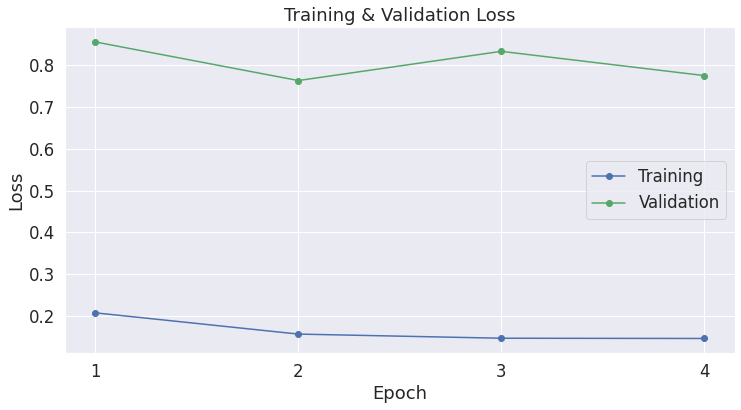

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

See test data results

In [ ]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(test_b_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions.
      result = model(b_input_ids, 
                     token_type_ids=None, 
                     attention_mask=b_input_mask,
                     return_dict=True)

  logits = result.logits

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  # Handsome made
  pred = np.array([0]*batch_size)
  for i in range(0, batch_size):
    if i % 3 == 0:
      best = i
      for j in range(i+1, i+3):
        if logits[j][1] - logits[j][0] > logits[best][1]- logits[best][0]:
          best = j
      for j in range(i, i+3):
        if best == j:
          pred[j] = 1

  # Store predictions and true labels
  predictions.append(pred)
  true_labels.append(label_ids)

print('    DONE.')

# Combine the predictions for each batch into a single list of 0s and 1s.
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.array(flat_predictions).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = [item for sublist in true_labels for item in sublist]
flat_true_labels = np.array(flat_true_labels)

bert_subB_accuracy = np.sum(flat_predictions == flat_true_labels) / len(flat_true_labels)

print("The BERT baseline achieved an accuracy rate of {}".format(bert_subB_accuracy))

Predicting labels for 540 test sentences...
    DONE.
The BERT baseline achieved an accuracy rate of 0.7592592592592593


F1 score

In [ ]:
print(classification_report(flat_true_labels, flat_predictions))

              precision    recall  f1-score   support

           0       0.82      0.82      0.82       360
           1       0.64      0.64      0.64       180

    accuracy                           0.76       540
   macro avg       0.73      0.73      0.73       540
weighted avg       0.76      0.76      0.76       540



## Use BertModel

Import BertModel

In [ ]:
model = BertModel.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)
# bert = BertModel.from_pretrained(
#     "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
#     num_labels = 2, # The number of output labels--2 for binary classification.
#                     # You can increase this for multi-class tasks.   
#     output_attentions = False, # Whether the model returns attentions weights.
#     output_hidden_states = False, # Whether the model returns all hidden-states.
# )

In [ ]:
model.cuda()

### Modify inputs as SWAG

Reshape so that 3 inputs as a group, and then create dataloader

In [ ]:
# for train set
train_b_inputs = train_b_token.input_ids
train_b_token_type = train_b_token.token_type_ids
train_b_labels = torch.tensor(train_b_data_concat['Label'])
train_b_masks = train_b_token.attention_mask

# for dev set
dev_b_inputs = dev_b_token.input_ids
dev_b_token_type = dev_b_token.token_type_ids
dev_b_labels = torch.tensor(dev_b_data_concat['Label'])
dev_b_masks = dev_b_token.attention_mask

# for test set
test_b_inputs = test_b_token.input_ids
test_b_token_type = test_b_token.token_type_ids
test_b_labels = torch.tensor(test_b_data_concat['Label'])
test_b_masks = test_b_token.attention_mask

# Create the DataLoader for our training set. (RandomSampler)
train_tensor_data = TensorDataset(train_b_inputs, train_b_masks, train_b_labels)
train_sampler = RandomSampler(train_tensor_data)
train_dataloader = DataLoader(train_tensor_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set. (SequentialSampler)
validation_tensor_data = TensorDataset(dev_b_inputs, dev_b_masks, dev_b_labels)
validation_sampler = SequentialSampler(validation_tensor_data)
validation_dataloader = DataLoader(validation_tensor_data, sampler=validation_sampler, batch_size=batch_size)

# Create the DataLoader for our test set. (SequentialSampler)
prediction_tensor_data = TensorDataset(test_b_inputs, test_b_masks, test_b_labels)
prediction_sampler = SequentialSampler(prediction_tensor_data)
prediction_dataloader = DataLoader(prediction_tensor_data, sampler=prediction_sampler, batch_size=batch_size)

In [ ]:
batch_size = 12

# function to convert as group
# "tp" determines whether use RandomSampler or SequentialSampler
def loader(input, tokentype, mask, label, tp):
  if tp == "train":
    # print(input)
    input = input.reshape([n,3,max_seq_len_b])
    mask = mask.reshape([n,3,max_seq_len_b])
    tokentype = tokentype.reshape([n,3,max_seq_len_b])
    # convert label from one-hot to class
    label = torch.tensor(np.argmax(np.array(label).reshape([n, 3]), axis = 1))
    tensor_data = TensorDataset(input,  mask, tokentype,label)
    sampler = RandomSampler(tensor_data)

  elif tp == "dev":
    input = input.reshape([m,3,max_seq_len_b])
    mask = mask.reshape([m,3,max_seq_len_b])
    tokentype = tokentype.reshape([m,3,max_seq_len_b])
    label = torch.tensor(np.argmax(np.array(label).reshape([m, 3]), axis = 1))
    tensor_data = TensorDataset(input, mask, tokentype,label)
    sampler = SequentialSampler(tensor_data)
  else:
    input = input.reshape([t,3,max_seq_len_b])
    mask = mask.reshape([t,3,max_seq_len_b])
    tokentype = tokentype.reshape([t,3,max_seq_len_b])
    label = torch.tensor(np.argmax(np.array(label).reshape([t, 3]), axis = 1))
    tensor_data = TensorDataset(input, mask, tokentype,label)
    sampler = SequentialSampler(tensor_data)
  
  loader = DataLoader(tensor_data, sampler=sampler, batch_size=batch_size)

  return loader

train_dataloader = loader(train_b_inputs, train_b_token_type,train_b_masks, train_b_data_concat['Label'], "train" )
validation_dataloader = loader(dev_b_inputs, dev_b_token_type,dev_b_masks, dev_b_data_concat['Label'], "dev")
prediction_dataloader = loader(test_b_inputs, test_b_token_type,test_b_masks, test_b_data_concat['Label'],"test")


In [ ]:
optimizer = AdamW(bertmc.parameters(),
                  lr = 1e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

# number of epochs
epochs = 4

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

NameError: ignored

Useful functions

In [ ]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# Helper function for formatting elapsed times.
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
for step, batch in enumerate(prediction_dataloader):
  print(batch[3])
  print(batch[0][1])

In [ ]:
t = [101,  2017,  2024,  2145,  4142,  2065,  2017,  2079,  2025,  2031,
          1037, 12251,  1012,  2053,  1010,  2023,  2987,  1005,  1056,  2191,
          3168,  2138,  2111,  2008,  2024,  4142,  2024,  4010,  2138,  1997,
          2037,  2540, 18276,  2668,  1998,  2065,  2017,  2079,  2025,  2031,
          1037,  2540,  2017,  2024,  3147,  2029,  2965,  2017,  2024,  2757,
          1012,   102]
a = bert_tokenizer.convert_ids_to_tokens(t)
a

### Training and testing

Start training

In [ ]:
loss_fn = nn.CrossEntropyLoss().to(device)
# logsm = nn.LogSoftmax()
relu = nn.ReLU
dropout = nn.Dropout(0.1)     
# dense layer 1 & 2
fc1 = nn.Linear(768,200)    
fc2 = nn.Linear(200,1)  

In [ ]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 266

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):
        # print(len(train_dataloader))

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 

        b_input_ids = batch[0]
        num = len(b_input_ids) # record the number of inputs in this batch
        b_input_ids = b_input_ids.reshape([num*3, max_seq_len_b]).to(device)

        b_input_mask = batch[1].reshape([num*3, max_seq_len_b]).to(device)
        b_token_type = batch[2].reshape([num*3, max_seq_len_b]).to(device)
        b_labels = batch[3].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # In PyTorch, calling `model` will in turn call the model's `forward` 
        # function and pass down the arguments. 
        result = model(b_input_ids, 
                       token_type_ids=b_token_type, 
                       attention_mask=b_input_mask,
                      return_dict = True)

        pooler_output = result.pooler_output
        pooler_output = pooler_output.reshape([num, 3, 768])
        # print(pooler_output)

        # add layers on top
        pooler_output = pooler_output.detach().cpu()
        x = fc1(pooler_output)
        x = dropout(x)
        x = fc2(x)
        
        # print(x)
        pred = x.reshape([num,3])
        # print(pred)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        pred = torch.tensor(pred).to(device)
        loss = loss_fn(pred, b_labels)
        # print("loss:****************",loss)
        total_train_loss += loss.item()
        # print("train loss:****************",total_train_loss)
        loss = loss.clone().detach().requires_grad_(True)
        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

        optimizer.zero_grad()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 

        b_input_ids = batch[0]
        num_dev = len(b_input_ids)
        b_input_ids = b_input_ids.reshape([num_dev*3, max_seq_len_b]).to(device)
        b_input_mask = batch[1].reshape([num_dev*3, max_seq_len_b]).to(device)
        b_token_type = batch[2].reshape([num_dev*3, max_seq_len_b]).to(device)
        b_labels = batch[3].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            result = model(b_input_ids, 
                           token_type_ids=b_token_type, 
                           attention_mask=b_input_mask,
                           return_dict=True)

        pooler_output = result.pooler_output
        pooler_output = pooler_output.reshape([num_dev, 3, 768])

        # add layers on top
        pooler_output = pooler_output.detach().cpu()
        x = fc1(pooler_output)
        x = dropout(x)
        x = fc2(x)
        pred = x.reshape([num_dev,3])
        # print(pred)
        pred_flat = np.argmax(pred.detach().numpy(),axis = 1)
        # print("pred_flat: **************",pred_flat)
        # print(pred)
        pred = torch.tensor(pred).to(device)
        loss = loss_fn(pred, b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        # pooler_output = pooler_output.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        # print(pooler_output)
        # print("label:**************",label_ids)

        
        # Calculate the accuracy for this batch of test sentences.
        pred_flat = pred_flat.flatten()
        labels_flat = label_ids.flatten()
        # print("pred_flat")
        # print(pred_flat)
        # print("labels_flat")
        # print(labels_flat)
        tmp_eval_accuracy = np.sum(pred_flat == labels_flat) / len(labels_flat)
        

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += tmp_eval_accuracy
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:109: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


  Batch    40  of    125.    Elapsed: 0:00:02.
  Batch    80  of    125.    Elapsed: 0:00:04.
  Batch   120  of    125.    Elapsed: 0:00:07.

  Average training loss: 1.09
  Training epcoh took: 0:00:07

Running Validation...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:207: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


  Accuracy: 0.38
  Validation Loss: 1.09
  Validation took: 0:00:01

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    125.    Elapsed: 0:00:02.
  Batch    80  of    125.    Elapsed: 0:00:04.
  Batch   120  of    125.    Elapsed: 0:00:06.

  Average training loss: 1.09
  Training epcoh took: 0:00:07

Running Validation...
  Accuracy: 0.41
  Validation Loss: 1.10
  Validation took: 0:00:01

======== Epoch 3 / 4 ========
Training...
  Batch    40  of    125.    Elapsed: 0:00:02.
  Batch    80  of    125.    Elapsed: 0:00:04.
  Batch   120  of    125.    Elapsed: 0:00:06.

  Average training loss: 1.09
  Training epcoh took: 0:00:07

Running Validation...
  Accuracy: 0.42
  Validation Loss: 1.09
  Validation took: 0:00:01

======== Epoch 4 / 4 ========
Training...
  Batch    40  of    125.    Elapsed: 0:00:02.
  Batch    80  of    125.    Elapsed: 0:00:04.
  Batch   120  of    125.    Elapsed: 0:00:06.

  Average training loss: 1.09
  Training epcoh took: 0:00:07

Running Val

Loss, accuracy, and time tables

In [ ]:
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,1.09,1.09,0.38,0:00:07,0:00:01
2,1.09,1.10,0.41,0:00:07,0:00:01
3,1.09,1.09,0.42,0:00:07,0:00:01
4,1.09,1.10,0.35,0:00:07,0:00:01


Plotting the loss

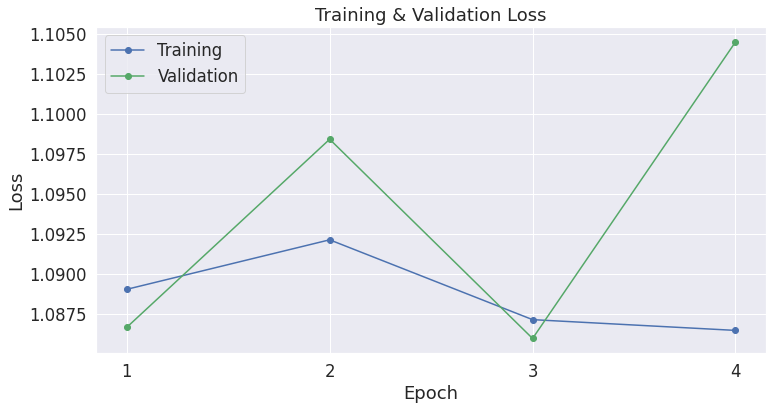

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

See test data results

In [ ]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(test_b_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids = batch[0]
  num_test = len(b_input_ids)
  b_input_ids = b_input_ids.reshape([num_test*3, max_seq_len_b]).to(device)
  b_input_mask = batch[1].reshape([num_test*3, max_seq_len_b]).to(device)
  b_token_type = batch[2].reshape([num_test*3, max_seq_len_b]).to(device)
  b_labels = batch[3].to(device)
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions.
    result = model(b_input_ids, 
                    token_type_ids=b_token_type, 
                    attention_mask=b_input_mask,
                    return_dict=True)

  pooler_output = result.pooler_output
  pooler_output = pooler_output.reshape([num_test, 3, 768])

  # add layers on top
  pooler_output = pooler_output.detach().cpu()
  x = fc1(pooler_output)
  x = dropout(x)
  x = fc2(x)
  pred = x.reshape([num_test,3])
  # print(pred)
  pred_flat = np.argmax(pred.detach().numpy(),axis = 1)
  # print("pred_flat: **************",pred_flat)
  # print(pred)
  pred_flat = torch.tensor(pred_flat).to(device)
  # loss = loss_fn(pred, b_labels)
            

  # Move logits and labels to CPU
  # logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  # # Handsome made
  # pred = np.array([0]*batch_size)
  # for i in range(0, batch_size):
  #   if i % 3 == 0:
  #     best = i
  #     for j in range(i+1, i+3):
  #       if logits[j][1] - logits[j][0] > logits[best][1]- logits[best][0]:
  #         best = j
  #     for j in range(i, i+3):
  #       if best == j:
  #         pred[j] = 1

  # Store predictions and true labels
  predictions.append(pred_flat)
  true_labels.append(label_ids)

print('    DONE.')

# Combine the predictions for each batch into a single list of 0s and 1s.
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.array(flat_predictions).flatten()


# Combine the correct labels for each batch into a single list.
flat_true_labels = [item for sublist in true_labels for item in sublist]
flat_true_labels = np.array(flat_true_labels)

bert_subB_accuracy = np.sum(flat_predictions == flat_true_labels) / len(flat_true_labels)

print("The BERT baseline achieved an accuracy rate of {}".format(bert_subB_accuracy))

Predicting labels for 300 test sentences...
    DONE.
The BERT baseline achieved an accuracy rate of 0.33


F1 score

In [ ]:
# print(classification_report(flat_true_labels, flat_predictions))

## Bert for Multiple Choice

#### Modify inputs as SWAG

Reshape so that 3 inputs as a group, and then create dataloader

In [21]:
# for train set
train_b_inputs = train_b_token.input_ids
train_b_token_type = train_b_token.token_type_ids
train_b_labels = torch.tensor(train_b_data_concat['Label'])
train_b_masks = train_b_token.attention_mask

# for dev set
dev_b_inputs = dev_b_token.input_ids
dev_b_token_type = dev_b_token.token_type_ids
dev_b_labels = torch.tensor(dev_b_data_concat['Label'])
dev_b_masks = dev_b_token.attention_mask

# for test set
test_b_inputs = test_b_token.input_ids
test_b_token_type = test_b_token.token_type_ids
test_b_labels = torch.tensor(test_b_data_concat['Label'])
test_b_masks = test_b_token.attention_mask

# # Create the DataLoader for our training set. (RandomSampler)
# train_tensor_data = TensorDataset(train_b_inputs, train_b_masks, train_b_labels)
# train_sampler = RandomSampler(train_tensor_data)
# train_dataloader = DataLoader(train_tensor_data, sampler=train_sampler, batch_size=batch_size)

# # Create the DataLoader for our validation set. (SequentialSampler)
# validation_tensor_data = TensorDataset(dev_b_inputs, dev_b_masks, dev_b_labels)
# validation_sampler = SequentialSampler(validation_tensor_data)
# validation_dataloader = DataLoader(validation_tensor_data, sampler=validation_sampler, batch_size=batch_size)

# # Create the DataLoader for our test set. (SequentialSampler)
# prediction_tensor_data = TensorDataset(test_b_inputs, test_b_masks, test_b_labels)
# prediction_sampler = SequentialSampler(prediction_tensor_data)
# prediction_dataloader = DataLoader(prediction_tensor_data, sampler=prediction_sampler, batch_size=batch_size)

NameError: ignored

In [21]:
batch_size = 12

# function to convert as group
# "tp" determines whether use RandomSampler or SequentialSampler
def loader(input, tokentype, mask, label, tp):
  if tp == "train":
    input = input.reshape([n,3,max_seq_len_b])
    mask = mask.reshape([n,3,max_seq_len_b])
    tokentype = tokentype.reshape([n,3,max_seq_len_b])
    # convert label from one-hot to class
    label = torch.tensor(np.argmax(np.array(label).reshape([n, 3]), axis = 1))
    tensor_data = TensorDataset(input,  mask, tokentype,label)
    sampler = RandomSampler(tensor_data)

  elif tp == "dev":
    input = input.reshape([m,3,max_seq_len_b])
    mask = mask.reshape([m,3,max_seq_len_b])
    tokentype = tokentype.reshape([m,3,max_seq_len_b])
    label = torch.tensor(np.argmax(np.array(label).reshape([m, 3]), axis = 1))
    tensor_data = TensorDataset(input, mask, tokentype,label)
    sampler = SequentialSampler(tensor_data)
  else:
    input = input.reshape([t,3,max_seq_len_b])
    mask = mask.reshape([t,3,max_seq_len_b])
    tokentype = tokentype.reshape([t,3,max_seq_len_b])
    label = torch.tensor(np.argmax(np.array(label).reshape([t, 3]), axis = 1))
    tensor_data = TensorDataset(input, mask, tokentype,label)
    sampler = SequentialSampler(tensor_data)
  
  loader = DataLoader(tensor_data, sampler=sampler, batch_size=batch_size)

  return loader

train_dataloader = loader(train_b_inputs, train_b_token_type,train_b_masks, train_b_data_concat['Label'], "train" )
validation_dataloader = loader(dev_b_inputs, dev_b_token_type,dev_b_masks, dev_b_data_concat['Label'], "dev")
prediction_dataloader = loader(test_b_inputs, test_b_token_type,test_b_masks, test_b_data_concat['Label'],"test")


Useful functions

In [22]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# Helper function for formatting elapsed times.
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

Optimizer and scheduler

Model

In [ ]:
bertmc = BertForMultipleChoice.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)
bertmc.cuda()

In [35]:
optimizer = AdamW(bertmc.parameters(),
                  lr = 1e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

# number of epochs
epochs = 4

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

Useful functions

###Start training

In [36]:
import random
import numpy as np

# Set the seed value all over the place to make this reproducible.
seed_val = 266

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    bertmc.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):
        # if step == 1:
        #     break
        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
          # As we unpack the batch, we'll also copy each tensor to the GPU using the 
          # `to` method.
        
          # `batch` contains three pytorch tensors:
          #   [0]: input ids 
          #   [1]: attention masks
          #   [2]: token type
          #   [3]: labels 

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_token_type = batch[2].to(device)
        b_labels = batch[3].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. 
        bertmc.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # In PyTorch, calling `model` will in turn call the model's `forward` 
        # function and pass down the arguments. 
        result = bertmc(b_input_ids, 
                        token_type_ids=b_token_type, 
                        attention_mask=b_input_mask,
                        labels = b_labels,
                      return_dict = True)
        
        loss = result.loss
        # logits = result.logits
        # pred = torch.tensor(logits).to(device)

        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        # loss = loss.clone().detach().requires_grad_(True)
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(bertmc.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

      # optimizer.zero_grad()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    bertmc.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    total_count = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        # Add batch to GPU
        # batch = tuple(t.to(device) for t in batch)

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_token_type = batch[2].to(device)
        b_labels = batch[3].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

        # Forward pass, calculate logit predictions.
        # token_type_ids is the same as the "segment ids", which 
        # differentiates sentence 1 and 2 in 2-sentence tasks.
            result_v = bertmc(b_input_ids, 
                            token_type_ids=b_token_type, 
                            attention_mask=b_input_mask,
                            labels = b_labels,
                            return_dict=True)

        loss = result_v.loss
        # print(loss)
        logits = result_v.logits
          
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        # pred = torch.tensor(logits)
        pred_flat = np.argmax(logits.to('cpu').numpy(), axis=1)
        pred_flat = pred_flat.flatten()

        label_ids = b_labels.to('cpu').numpy()
        labels_flat = label_ids.flatten()


        # Calculate the accuracy for this batch of validation sentences.
        # tmp_eval_accuracy = np.sum(pred_flat == labels_flat) / len(labels_flat)
        tmp_eval_count = np.sum(pred_flat == labels_flat)
        # total_eval_accuracy += tmp_eval_accuracy
        total_count += tmp_eval_count

          

    # Report the final accuracy for this validation run.
    # avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    avg_val_accuracy = total_count/ m

    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)

    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
  
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    834.    Elapsed: 0:00:06.
  Batch    80  of    834.    Elapsed: 0:00:12.
  Batch   120  of    834.    Elapsed: 0:00:18.
  Batch   160  of    834.    Elapsed: 0:00:24.
  Batch   200  of    834.    Elapsed: 0:00:30.
  Batch   240  of    834.    Elapsed: 0:00:36.
  Batch   280  of    834.    Elapsed: 0:00:42.
  Batch   320  of    834.    Elapsed: 0:00:48.
  Batch   360  of    834.    Elapsed: 0:00:54.
  Batch   400  of    834.    Elapsed: 0:01:00.
  Batch   440  of    834.    Elapsed: 0:01:06.
  Batch   480  of    834.    Elapsed: 0:01:12.
  Batch   520  of    834.    Elapsed: 0:01:18.
  Batch   560  of    834.    Elapsed: 0:01:24.
  Batch   600  of    834.    Elapsed: 0:01:29.
  Batch   640  of    834.    Elapsed: 0:01:35.
  Batch   680  of    834.    Elapsed: 0:01:41.
  Batch   720  of    834.    Elapsed: 0:01:47.
  Batch   760  of    834.    Elapsed: 0:01:53.
  Batch   800  of    834.    Elapsed: 0:01:59.

  Average traini

In [40]:
# Display floats with two decimal places.
pd.set_option('precision', 4)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.5389,0.4729,0.8295,0:02:04,0:00:04
2,0.2897,0.4412,0.8445,0:02:04,0:00:04
3,0.1778,0.5315,0.8395,0:02:04,0:00:03
4,0.1203,0.5726,0.8435,0:02:04,0:00:04


Plotting the loss

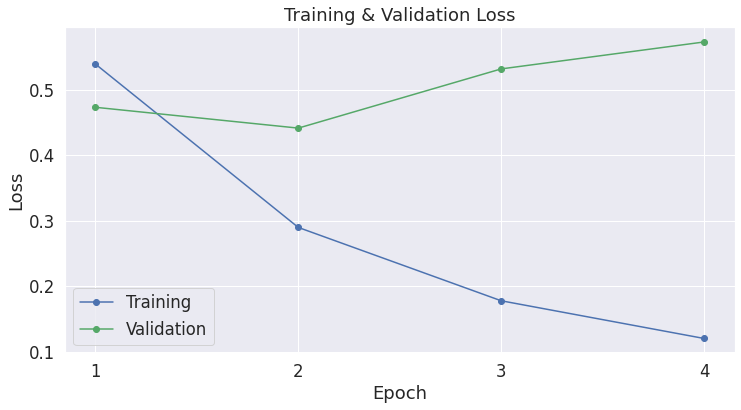

In [42]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

See test data results

In [45]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(t))

# Put model in evaluation mode
bertmc.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader

  b_input_ids = batch[0].to(device)
  b_input_mask = batch[1].to(device)
  b_token_type = batch[2].to(device)
  b_labels = batch[3].to(device)
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions.
    result = bertmc(b_input_ids, 
                    token_type_ids=b_token_type, 
                    attention_mask=b_input_mask,
                   labels = b_labels,
                    return_dict=True)

  logits = result.logits
  loss = result.loss

  # print(pred)
  pred = torch.tensor(logits)
  pred_flat = np.argmax(pred.to('cpu').numpy(), axis=1)
  pred_flat = pred_flat.flatten()
            

  # Move logits and labels to CPU
  # logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  predictions.append(pred_flat)
  true_labels.append(label_ids)

print('    DONE.')

# Combine the predictions for each batch into a single list of 0s and 1s.
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.array(flat_predictions).flatten()


# Combine the correct labels for each batch into a single list.
flat_true_labels = [item for sublist in true_labels for item in sublist]
flat_true_labels = np.array(flat_true_labels)

bert_subB_accuracy = np.sum(flat_predictions == flat_true_labels) / len(flat_true_labels)

print("The BERT baseline achieved an accuracy rate of {}".format(bert_subB_accuracy))

Predicting labels for 1,000 test sentences...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


    DONE.
The BERT baseline achieved an accuracy rate of 0.84


# DeBERTA

Tokenize

In [22]:
# deberta_v2_tokenizer = DebertaV2Tokenizer.from_pretrained('microsoft/deberta-v2-xlarge')
deberta_v2_tokenizer = DebertaTokenizer.from_pretrained('microsoft/deberta-base')

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Max sentence length: 52


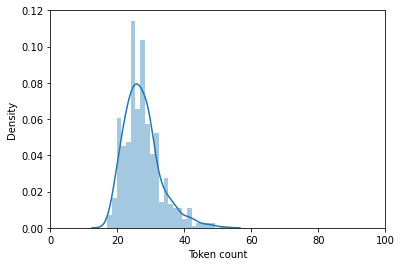

In [17]:
token_b_lens = []
for txt in train_b_data_concat['ConnectSent']:
  tokens_b = deberta_v2_tokenizer.encode(str(txt), max_length=512)
  token_b_lens.append(len(tokens_b))

sns.distplot(token_b_lens)
plt.xlim([0, 100])
plt.xlabel('Token count')

print("Max sentence length:", max(token_b_lens))

In [23]:
# As a pair
max_seq_len_b = 36
train_b_token = deberta_v2_tokenizer(
    train_b_data_concat['FalseSent'].tolist(),
    train_b_data_concat['Option'].tolist(),
    max_length = max_seq_len_b,
    pad_to_max_length=True,
    truncation=True, 
    return_tensors="pt"
    )

dev_b_token = deberta_v2_tokenizer(
    dev_b_data_concat['FalseSent'].tolist(),
    dev_b_data_concat['Option'].tolist(),
    max_length = max_seq_len_b,
    pad_to_max_length=True,
    truncation=True, 
    return_tensors="pt"
    )

test_b_token = deberta_v2_tokenizer(
    test_b_data_concat['FalseSent'].tolist(),
    test_b_data_concat['Option'].tolist(),
    max_length = max_seq_len_b,
    pad_to_max_length=True,
    truncation=True, 
    return_tensors="pt"
    )

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [24]:
train_b_inputs = train_b_token.input_ids
train_b_token_type = train_b_token.token_type_ids
train_b_labels = torch.tensor(train_b_data_concat['Label'])
train_b_masks = train_b_token.attention_mask

# for dev set
dev_b_inputs = dev_b_token.input_ids
dev_b_token_type = dev_b_token.token_type_ids
dev_b_labels = torch.tensor(dev_b_data_concat['Label'])
dev_b_masks = dev_b_token.attention_mask

# for test set
test_b_inputs = test_b_token.input_ids
test_b_token_type = test_b_token.token_type_ids
test_b_labels = torch.tensor(test_b_data_concat['Label'])
test_b_masks = test_b_token.attention_mask

In [25]:
batch_size = 8

# function to convert as group
# "tp" determines whether use RandomSampler or SequentialSampler
def loader(input, tokentype, mask, label, tp):
  if tp == "train":
    input = input.reshape([n,3,max_seq_len_b])
    mask = mask.reshape([n,3,max_seq_len_b])
    tokentype = tokentype.reshape([n,3,max_seq_len_b])
    # convert label from one-hot to class
    label = torch.tensor(np.argmax(np.array(label).reshape([n, 3]), axis = 1))
    tensor_data = TensorDataset(input,  mask, tokentype,label)
    sampler = RandomSampler(tensor_data)

  elif tp == "dev":
    input = input.reshape([m,3,max_seq_len_b])
    mask = mask.reshape([m,3,max_seq_len_b])
    tokentype = tokentype.reshape([m,3,max_seq_len_b])
    label = torch.tensor(np.argmax(np.array(label).reshape([m, 3]), axis = 1))
    tensor_data = TensorDataset(input, mask, tokentype,label)
    sampler = SequentialSampler(tensor_data)
  else:
    input = input.reshape([t,3,max_seq_len_b])
    mask = mask.reshape([t,3,max_seq_len_b])
    tokentype = tokentype.reshape([t,3,max_seq_len_b])
    label = torch.tensor(np.argmax(np.array(label).reshape([t, 3]), axis = 1))
    tensor_data = TensorDataset(input, mask, tokentype,label)
    sampler = SequentialSampler(tensor_data)
  
  loader = DataLoader(tensor_data, sampler=sampler, batch_size=batch_size)

  return loader

train_dataloader = loader(train_b_inputs, train_b_token_type,train_b_masks, train_b_data_concat['Label'], "train" )
validation_dataloader = loader(dev_b_inputs, dev_b_token_type,dev_b_masks, dev_b_data_concat['Label'], "dev")
prediction_dataloader = loader(test_b_inputs, test_b_token_type,test_b_masks, test_b_data_concat['Label'],"test")

Model

In [ ]:
class DeBERTaForMultipleChoice(BertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)

        self.bert = BertModel(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, 1)

        self.init_weights()

In [ ]:
# debertav2 = DebertaV2Model.from_pretrained(
#     'microsoft/deberta-v2-xlarge',
#     output_attentions = False,
#     output_hidden_states = False,
# )
debertav2 = DebertaModel.from_pretrained(
    'microsoft/deberta-base',
    output_attentions = False,
    output_hidden_states = False,
)
debertav2.cuda()

In [56]:
optimizer = AdamW(debertav2.parameters(),
                  lr = 5e-3, 
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

# number of epochs
epochs = 4

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [51]:
loss_fn = nn.CrossEntropyLoss().to(device)
relu = nn.ReLU
dropout = nn.Dropout(0.1)     
# fc1 = nn.Linear(1536,1)  
fc1 = nn.Linear(768,1)    

In [52]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# Helper function for formatting elapsed times.
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [59]:
seed_val = 266
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []

total_t0 = time.time()

for epoch_i in range(epochs):

    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    debertav2.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):
        if step == 1:
            break
        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # b_input_ids = batch[0].to(device)
        # b_input_mask = batch[1].to(device)
        # b_token_type = batch[2].to(device)
        # b_labels = batch[3].to(device)
        # print(b_input_ids[0])

        b_input_ids = batch[0]
        num = len(b_input_ids) # record the number of inputs in this batch
        b_input_ids = b_input_ids.reshape([num*3, max_seq_len_b]).to(device)

        b_input_mask = batch[1].reshape([num*3, max_seq_len_b]).to(device)
        b_token_type = batch[2].reshape([num*3, max_seq_len_b]).to(device)
        b_labels = batch[3].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. 
        debertav2.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # In PyTorch, calling `model` will in turn call the model's `forward` 
        # function and pass down the arguments. 
        result = debertav2(b_input_ids, 
                        token_type_ids=b_token_type, 
                        attention_mask=b_input_mask,
                        # labels = b_labels,
                      return_dict = True)
        
        # loss = result.loss
        # logits = result.logits
        # pred = torch.tensor(logits).to(device)

        last_hidden_states = result.last_hidden_state
        cls = last_hidden_states[:,0,:]
        # cls = cls.reshape([num, 3, 1536])
        cls = cls.reshape([num, 3, 768])

        # add layers on top
        cls = cls.detach().cpu()
        x = fc1(cls)
        x = dropout(x)

        logits = x.reshape([num,3])
        logits = torch.tensor(logits).to(device)
        print(logits)
        loss = loss_fn(logits, b_labels)

        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss = loss.clone().detach().requires_grad_(True)
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(debertav2.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

      # optimizer.zero_grad()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))


    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    debertav2.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 

        b_input_ids = batch[0]
        num_dev = len(b_input_ids)
        b_input_ids = b_input_ids.reshape([num_dev*3, max_seq_len_b]).to(device)
        b_input_mask = batch[1].reshape([num_dev*3, max_seq_len_b]).to(device)
        b_token_type = batch[2].reshape([num_dev*3, max_seq_len_b]).to(device)
        b_labels = batch[3].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            result = debertav2(b_input_ids, 
                           token_type_ids=b_token_type, 
                           attention_mask=b_input_mask,
                           return_dict=True)

        last_hidden_states = result.last_hidden_state
        cls = last_hidden_states[:,0,:]
        # cls = cls.reshape([num_dev, 3, 1536])
        cls = cls.reshape([num, 3, 768])
        # add layers on top
        cls = cls.detach().cpu()
        x = fc1(cls)
        x = dropout(x)
        logits = x.reshape([num_dev,3])
        # print(pred)
        pred = np.argmax(logits.detach().numpy(),axis = 1)
        # print("pred_flat: **************",pred_flat)
        # print(pred)
        # pred = torch.tensor(pred).to(device)
        logits = torch.tensor(logits).to(device)
        loss = loss_fn(logits, b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        # pooler_output = pooler_output.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        # print(pooler_output)
        # print("label:**************",label_ids)

        
        # Calculate the accuracy for this batch of test sentences.
        pred_flat = pred.flatten()
        labels_flat = label_ids.flatten()
        # print("pred_flat")
        # print(pred_flat)
        # print("labels_flat")
        # print(labels_flat)
        tmp_eval_count = np.sum(pred_flat == labels_flat)
        

        # accumulate it over all batches.
        total_eval_accuracy += tmp_eval_count
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / m
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
tensor([[-0.3009,  0.0826,  0.0291],
        [ 0.0345,  0.4254,  0.0353],
        [-0.0352,  0.0295,  0.0000],
        [ 0.4220,  0.4645,  0.0331],
        [ 0.0428,  0.0455,  0.0250],
        [ 0.3689, -0.0046,  0.0267],
        [ 0.0124,  0.0204, -0.0478],
        [ 0.1461,  0.0026,  0.0371]], device='cuda:0')

  Average training loss: 0.04
  Training epcoh took: 0:00:00

Running Validation...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:190: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


  Accuracy: 0.36
  Validation Loss: 1.10
  Validation took: 0:00:01

======== Epoch 2 / 4 ========
Training...
tensor([[ 0.0000,  0.4333,  0.0249],
        [ 0.0352,  0.1442, -0.0431],
        [-0.3112,  0.0141, -0.0000],
        [-0.0408,  0.0073, -0.3190],
        [-0.0398,  0.1206,  0.0402],
        [ 0.1393,  0.1481,  0.0000],
        [ 0.0000,  0.0000, -0.0588],
        [ 0.0253, -0.0416,  0.0323]], device='cuda:0')

  Average training loss: 0.04
  Training epcoh took: 0:00:00

Running Validation...
  Accuracy: 0.36
  Validation Loss: 1.10
  Validation took: 0:00:01

======== Epoch 3 / 4 ========
Training...
tensor([[-0.0665, -0.0000,  0.0230],
        [ 0.0407, -0.0000,  0.4274],
        [ 0.0000, -0.0000, -0.0369],
        [ 0.0301,  0.0248,  0.0215],
        [-0.0406,  0.0293,  0.0000],
        [ 0.0199,  0.0000,  0.1476],
        [ 0.1331,  0.0316,  0.0000],
        [-0.3876,  0.0246,  0.0312]], device='cuda:0')

  Average training loss: 0.04
  Training epcoh took: 0:00:00

Ru

In [58]:
# Display floats with two decimal places.
pd.set_option('precision', 4)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.0449,1.0989,0.365,0:00:00,0:00:01
2,0.0436,1.0984,0.360,0:00:00,0:00:01
3,0.0449,1.0984,0.360,0:00:00,0:00:01
4,0.0476,1.0977,0.395,0:00:00,0:00:01


Plotting the loss

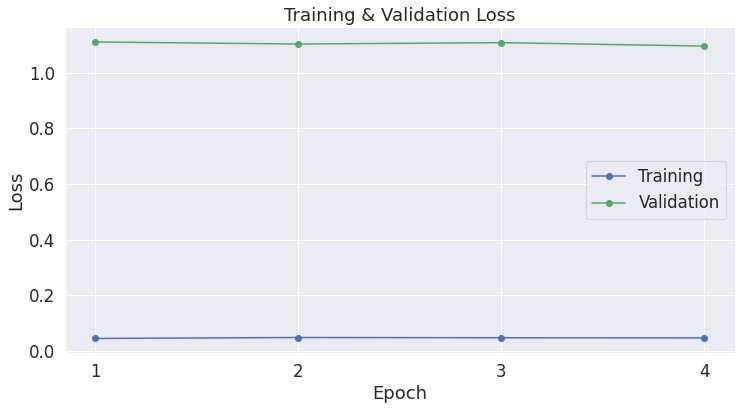

In [48]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

See test data results

In [45]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(t))

# Put model in evaluation mode
debertav2.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader

  b_input_ids = batch[0]
  num_test = len(b_input_ids)
  b_input_ids = b_input_ids.reshape([num_test*3, max_seq_len_b]).to(device)
  b_input_mask = batch[1].reshape([num_test*3, max_seq_len_b]).to(device)
  b_token_type = batch[2].reshape([num_test*3, max_seq_len_b]).to(device)
  b_labels = batch[3].to(device)
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions.
    result = debertav2(b_input_ids, 
                    token_type_ids=b_token_type, 
                    attention_mask=b_input_mask,
                  #  labels = b_labels,
                    return_dict=True)

  last_hidden_states = result.last_hidden_state
  cls = last_hidden_states[:,0,:]
  # cls = cls.reshape([num_dev, 3, 1536])
  cls = cls.reshape([num, 3, 768])
  # add layers on top
  cls = cls.detach().cpu()
  x = fc1(cls)
  x = dropout(x)


  logits = x.reshape([num_test,3])
  # print(pred)
  pred = np.argmax(logits.detach().numpy(),axis = 1)
  # print("pred_flat: **************",pred_flat)
  # print(pred)
  # pred = torch.tensor(pred).to(device)
  logits = torch.tensor(logits).to(device)

  # print(pred)
  pred = torch.tensor(pred)
  pred = np.argmax(logits.to('cpu').numpy(), axis=1)
  pred_flat = pred.flatten()
            

  # Move logits and labels to CPU
  # logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  predictions.append(pred_flat)
  true_labels.append(label_ids)

print('    DONE.')

# Combine the predictions for each batch into a single list of 0s and 1s.
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.array(flat_predictions).flatten()


# Combine the correct labels for each batch into a single list.
flat_true_labels = [item for sublist in true_labels for item in sublist]
flat_true_labels = np.array(flat_true_labels)

bert_subB_accuracy = np.sum(flat_predictions == flat_true_labels) / len(flat_true_labels)

print("The DeBERTa achieved an accuracy rate of {}".format(bert_subB_accuracy))

Predicting labels for 1,000 test sentences...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


    DONE.
The DeBERTa achieved an accuracy rate of 0.325


# Other

In [ ]:
# freeze all bert parameters
for param in model.parameters():
  param.requires_grad = False

In [ ]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)     
      # relu activation function
      self.relu =  nn.ReLU()
      # dense layer 1
      self.fc1 = nn.Linear(768,512)    
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):
      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask)    

      x = self.fc1(cls_hs)
      x = self.relu(x)
      x = self.dropout(x)
      x = self.fc2(x)
      # apply softmax activation
      x = self.softmax(x)

      return x

In [ ]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

model(inputa, inputb)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight('balanced', np.unique(train_b_data_concat['Label']), train_b_data_concat['Label'])

print(class_wts)

[0.75 1.5 ]


In [ ]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights) 


In [ ]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [ ]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(validation_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(validation_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(validation_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

Start Model Training

In [ ]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 4


TypeError: ignored

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

sent1 = "He poured orange juice on his cereal. No, this doesn't make sense because Orange juice is usually bright orange."
sent2 = "He poured orange juice on his cereal. No, this doesn't make sense because Orange juice doesn't taste good on cereal."
sent3 = "He poured orange juice on his cereal. No, this doesn't make sense because Orange juice is sticky if you spill it on the table."

tokens = bert_tokenizer(sent2, return_tensors="pt")
tokens = tokens.to(device)
outputs = model(**tokens)

cls = outputs[0][:,0,:]

#hidden = tf.keras.layers.Dense(200, activation="relu")(cls)


# prediction_logits = outputs.prediction_logits.detach().cpu().numpy()
# seq_relationship_logits = outputs.seq_relationship_logits.detach().cpu().numpy()

# loss = outputs.loss
# logits = outputs.logits.detach().cpu()


TypeError: ignored

In [ ]:
sent1 = "He poured orange juice on his cereal. No, this doesn't make sense because Orange juice is usually bright orange."
# sent2 = "He poured orange juice on his cereal. No, this doesn't make sense because Orange juice doesn't taste good on cereal."
# sent3 = "He poured orange juice on his cereal. No, this doesn't make sense because Orange juice is sticky if you spill it on the table."
tokens = bert_tokenizer(sent1)
inputs = torch.tensor(tokens.input_ids)
masks = torch.tensor(tokens.attention_mask)



In [ ]:
model(**inputs)

TypeError: ignored

In [ ]:
tokens

{'input_ids': tensor([[  101,  2002,  8542,  4589, 10869,  2006,  2010, 20943,  1012,  2053,
          1010,  2023,  2987,  1005,  1056,  2191,  3168,  2138,  4589, 10869,
          2003,  2788,  4408,  4589,  1012,   102]], device='cuda:0'), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1]], device='cuda:0')}

In [ ]:
logits1 = logits
logits1

tensor([[-0.4697,  0.1944]])

In [ ]:
logits2 = logits
logits2

tensor([[-0.4296,  0.1490]])

In [ ]:
logits3 = logits
logits3

tensor([[-0.3848,  0.0318]])

In [ ]:
from torch.nn import functional as F
softm3= F.softmax(logits3, dim = -1)
softm2= F.softmax(logits2, dim = -1)
softm1= F.softmax(logits1, dim = -1)

In [ ]:
softm1,softm2,softm3

(tensor([[0.3398, 0.6602]]),
 tensor([[0.3593, 0.6407]]),
 tensor([[0.3973, 0.6027]]))

In [ ]:
prediction_logits.shape

(1, 26, 30522)

In [ ]:
cls = prediction_logits[:,0,:]
cls

array([[-7.5102954, -7.487588 , -7.4400187, ..., -6.6273246, -6.732948 ,
        -4.2820334]], dtype=float32)

In [ ]:
pred = np.argmax(logits3, axis=1)
pred_flat = pred.flatten()

In [ ]:
pred

array([1])

In [ ]:
seq_relationship_logits

tensor([[ 4.3359, -3.3424]], device='cuda:0', grad_fn=<AddmmBackward>)

In [ ]:
model.cuda()

BERT_Arch(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 203 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [ ]:
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

### Playaround

In [ ]:
from transformers import BertTokenizer, BertForMultipleChoice
import torch
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForMultipleChoice.from_pretrained('bert-base-uncased')
prompt = "In Italy, pizza served in formal settings, such as at a restaurant, is presented unsliced."
choice0 = "It is eaten with a fork and a knife."
choice1 = "It is eaten while held in the hand."
labels = torch.tensor(0).unsqueeze(0)  # choice0 is correct (according to Wikipedia ;)), batch size 1
encoding = tokenizer([[prompt, prompt], [choice0, choice1]], return_tensors='pt', padding=True)
outputs = model(**{k: v.unsqueeze(0) for k,v in encoding.items()}, labels=labels)  # batch size is 1
# the linear classifier still needs to be trained
loss = outputs.loss
logits = outputs.logits

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMultipleChoice: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForMultipleChoice from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMultipleChoice from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMultipleChoice were not initialized from the model checkpoint at bert-base-uncased and are newly

In [ ]:
prompt = "In Italy, pizza served in formal settings, such as at a restaurant, is presented unsliced."
choice0 = "It is eaten with a fork and a knife."
choice1 = "It is eaten while held in the hand."
choice2 = "It is not eaten."
labels = torch.tensor(0).unsqueeze(0)  # choice0 is correct (according to Wikipedia ;)), batch size 1
encoding = tokenizer([[prompt, prompt,prompt], [choice0, choice1, choice2]], return_tensors='pt', padding=True)
outputs = model(**{k: v.unsqueeze(0) for k,v in encoding.items()}, labels=labels)  # batch size is 1
# the linear classifier still needs to be trained
loss = outputs.loss
logits = outputs.logits

ValueError: ignored

In [ ]:
logits

tensor([[0.8936, 0.9201]], grad_fn=<ViewBackward>)

# DeBERTa